#  Supervised ML on Imbalanced Dataset
In this notebook, we train three classifiers on the imbalanced dataset by implementing cost sensitive method, undersampling, and SMOTE

In [71]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Dimensionality reduction
from sklearn.decomposition import PCA

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

# Pickle
import joblib

In [72]:
# Import custom class
%run -i '../helper/transfxn.py'
%run -i '../helper/ml.py'

# Load data

In [3]:
# Load cleaned data
df = pd.read_csv('../data/clean_data.csv')
df = df.sample(frac =1).reset_index(drop = True) # shuffle
print('Data size',df.shape) # data size
df.head()

Data size (3817613, 23)


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,FATAL,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,2009,September,Tuesday,20.0,0,2.0,Any other two-vehicle - different direction,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1993.0,1.0,M,21.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,1547801
1,2002,July,Friday,20.0,0,1.0,Hit a stationary object,Non-intersection,"Overcast, cloudy but no precipitation",Wet,...,Light Duty Vehicle,1988.0,1.0,F,23.0,Driver,Injury,Safety device used,Motor Vehicle Driver,479186
2,2006,September,Monday,14.0,0,2.0,Right angle collision,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1993.0,1.0,F,42.0,Driver,Injury,Safety device used,Motor Vehicle Driver,1182369
3,2006,May,Thursday,17.0,0,2.0,Rear-end collision,Non-intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,2004.0,1.0,M,28.0,Driver,Injury,Safety device used,Motor Vehicle Driver,1126722
4,2003,December,Monday,14.0,1,2.0,Any other two-vehicle - different direction,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1989.0,1.0,F,65.0,Driver,Fatality,No safety device used,Motor Vehicle Driver,713353


# Categorization (Coarse Classification)

From 01-data_cleaning.ipynb we can see that the data contains numerous categorical variables with many different values. Each level of the category would create a dummy variable in our model, therefore there will be many redundant features in the model due to infrequent categories.

We would like to create categories of values such that fewer parameters will have to be estimated and probably a more robust model can be obtained. We are going to categorize the values based on similar odds ratio.

## 1. Collision configuration
We will keep only four categories with the largest odds and aggregate others

In [4]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'C_CONF', aggfunc = 'count')
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [38.68, 157.85, 106.15, 21.62, 7.53, 38.92, 56.74, 38.08, 98.27, 25.48, 28.71, 281.09, 68.63, 84.74, 44.05, 69.39, 69.81, 121.64]


C_CONF,Any other single-vehicle,Any other two-vehicle - different direction,Any other two-vehicle - same direction,Approaching side-swipe,Head-on collision,Hit a moving object,Hit a parked motor vehicle,Hit a stationary object,Left turn across opposing traffic,Ran off left shoulder,Ran off right shoulder,Rear-end collision,Right angle collision,Right turn,Rollover on roadway,Side swipe,left turn conflict,right turn conflict
FATAL,,,,,,,,,,,,,,,,,,
0,333464,401728,5838,24730,127288,34365,29731,82363,290097,96921,128527,1323634,607543,41355,8458,152307,38883,29072
1,8621,2545,55,1144,16910,883,524,2163,2952,3804,4476,4709,8852,488,192,2195,557,239


In [5]:
coll_dict = {'Hit a moving object':'other', 
             'Hit a stationary object':'other', 
             'Ran off left shoulder':'other',
            'Ran off right shoulder':'other', 
             'Rollover on roadway': 'Rollover on roadway', 
             'Any other single-vehicle ':'other',
            'Right turn':'other',
             'Head-on collision': 'Head-on collision',
             'Rear-end collision': 'Rear-end collision', 
            'left turn conflict':'other',  
             'Left turn across opposing traffic':'other',
            'right turn conflict':'other', 
             'Right angle collision':'other', 
             'Hit a parked motor vehicle':'other',
            'Approaching side-swipe':'other', 
            'Any other two-vehicle - different direction': 'Any other two-vehicle - different direction', 
             'Side swipe':'other', 
            'Any other two-vehicle - same direction':'other'}

df['C_CONF'].replace(coll_dict, inplace = True)

df.C_CONF.value_counts()

other                                          1932149
Rear-end collision                             1328343
Any other two-vehicle - different direction     404273
Head-on collision                               144198
Rollover on roadway                               8650
Name: C_CONF, dtype: int64

## 2. Roadway configuration

In [6]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'C_RCFG', aggfunc = 'count')
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [107.4, 50.32, 124.5, 119.15, 37.34, 6.91, 41.74, 286.4, 184.57, 33.51]


C_RCFG,At an intersection,"Bridge, overpass, viaduct",Express lane of a freeway system,Intersection with parking lot entrance,Non-intersection,Passing or climbing lane,Railroad level crossing,Ramp,Traffic circle,Tunnel or underpass
FATAL,,,,,,,,,,
0,1996193,34319,249,217095,1483962,318,11561,7160,1292,4155
1,18586,682,2,1822,39738,46,277,25,7,124


In [7]:
roadway_dict = {'Non-intersection': 'other', 
                'At an intersection':'At an intersection', 
                'Intersection with parking lot entrance': 'Intersection with parking lot entrance',
                'Railroad level crossing': 'other',
               'Bridge, overpass, viaduct': 'other', 
                'Tunnel or underpass': 'other', 
                'Passing or climbing lane': 'other',
               'Ramp': 'Express lane of a freeway system', 
                'Traffic circle': 'Express lane of a freeway system',
                'Express lane of a freeway system': 'Express lane of a freeway system'}

df['C_RCFG'].replace(roadway_dict, inplace = True)

df.C_RCFG.value_counts()

At an intersection                        2014779
other                                     1575182
Intersection with parking lot entrance     218917
Express lane of a freeway system             8735
Name: C_RCFG, dtype: int64

## 3. Weather condition

In [8]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'C_WTHR', aggfunc = 'count', fill_value = 0)
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [63.63, 39.32, 50.57, 83.27, 53.22, 31.79, 23.98]


C_WTHR,Clear and sunny,"Freezing rain, sleet, hail","Overcast, cloudy but no precipitation",Raining,Snowing,Strong wind,Visibility limitation
FATAL,,,,,,,
0,2688648,19975,346496,416193,222200,9410,53382
1,42254,508,6852,4998,4175,296,2226


In [9]:
wthr_dict = {'Clear and sunny': 'Clear and sunny',
             'Overcast, cloudy but no precipitation': 'Overcast, cloudy but no precipitation',
              'Raining': 'Raining',
            'Snowing' : 'Snowing', 
             'Freezing rain, sleet, hail' :'other',
              'Visibility limitation':'Visibility limitation',
              'Strong wind': 'other'}

df['C_WTHR'].replace(wthr_dict, inplace = True)

df.C_WTHR.value_counts()

Clear and sunny                          2730902
Raining                                   421191
Overcast, cloudy but no precipitation     353348
Snowing                                   226375
Visibility limitation                      55608
other                                      30189
Name: C_WTHR, dtype: int64

## 4. Road surface

In [10]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'C_RSUR', aggfunc = 'count', fill_value = 0)
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [60.62, 59.33, 49.43, 27.96, 231.67, 21.5, 50.33, 52.1, 76.62]


C_RSUR,"Dry, normal",Flooded,Icy,Muddy,Oil,Sand/gravel/dirt,Slush,Snow,Wet
FATAL,,,,,,,,,
0,2564900,178,204511,2908,695,15694,53899,167814,745705
1,42308,3,4137,104,3,730,1071,3221,9732


In [11]:
roadsur_dict = {'Dry, normal':'Dry, normal', 
                'Wet': 'Wet', 
                'Snow': 'Snow', 
                'Slush':'Snow', 
                'Icy': 'other', 
                'Sand/gravel/dirt':'other',
                'Muddy':'other', 
                 'Oil': 'Oil', 
                'Flooded': 'Dry, normal'}

df['C_RSUR'].replace(roadsur_dict, inplace = True)

df.C_RSUR.value_counts()

Dry, normal    2607389
Wet             755437
other           228084
Snow            226005
Oil                698
Name: C_RSUR, dtype: int64

## 5. Road alignment

In [12]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'C_RALN', aggfunc = 'count', fill_value = 0)
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [28.02, 26.27, 24.51, 78.19, 51.8, 30.45]


C_RALN,Bottom of hill or gradient,Curved and level,Curved with gradient,Straight and level,Straight with gradient,Top of hill or gradient
FATAL,,,,,,
0,16170,235110,138931,2944003,398981,23109
1,577,8949,5668,37653,7703,759


In [13]:
roadall_dist = {'Straight and level':'Straight and level',
                'Straight with gradient':'Straight with gradient', 
                'Curved and level': 'Curved',
               'Curved with gradient':'Curved', 
                'Top of hill or gradient': 'Top of hill or gradient',
                'Bottom of hill or gradient': 'Bottom of hill or gradient'}

df['C_RALN'].replace(roadall_dist, inplace = True)

df.C_RALN.value_counts()

Straight and level            2981656
Straight with gradient         406684
Curved                         388658
Top of hill or gradient         23868
Bottom of hill or gradient      16747
Name: C_RALN, dtype: int64

## 6. Vehicle type

In [14]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'V_TYPE', aggfunc = 'count', fill_value = 0)
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [219.67, 41.87, 69.32, 24.29, 44.94, 61.79, 15.41, 12.8, 27.58, 105.57, 116.2, 23.47, 34.91]


V_TYPE,Bicycle,Fire engine,Light Duty Vehicle,Motorcycle and moped,Other trucks and vans,Panel/cargo van,Purpose-built motorhome,Road tractor,School bus,Smaller school bus,Street car,Unit trucks,Urban and Intercity Bus
FATAL,,,,,,,,,,,,,
0,3954,628,3400890,61385,109832,45909,1572,39039,14284,739,1743,44424,31905
1,18,15,49062,2527,2444,743,102,3051,518,7,15,1893,914


In [15]:
vehtype_dict ={'Light Duty Vehicle': 'Light Duty Vehicle', 
               'Other trucks and vans': 'Other trucks and vans', 
               'Urban and Intercity Bus': 'Urban and Intercity Bus',
              'Construction equipment': 'Construction equipment',
               'Bicycle': 'Bicycle', 
               'Unit trucks': 'other', 
               'Road tractor': 'Road tractor',
              'School bus': 'other', 
               'Snowmobile': 'Snowmobile',
               'Motorcycle and moped': 'other',
               'Street car': 'Street car',
              'Panel/cargo van': 'Light Duty Vehicle', 
               'Off road vehicles': 'Off road vehicles', 
               'Farm equipment': 'Farm equipment', 
               'Purpose-built motorhome': 'Road tractor',
              'Smaller school bus': 'Street car',
               'Fire engine':'Other trucks and vans'}

df['V_TYPE'].replace(vehtype_dict, inplace = True)

df.V_TYPE.value_counts()

Light Duty Vehicle         3496604
other                       125031
Other trucks and vans       112919
Road tractor                 43764
Urban and Intercity Bus      32819
Bicycle                       3972
Street car                    2504
Name: V_TYPE, dtype: int64

## 7. Traffic control

In [16]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'C_TRAF', aggfunc = 'count', fill_value = 0)
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [33.86, 19.97, 42.12, 24.0, 184.59, 136.73, 20.37, 9.04, 10.14, 226.69, inf, 131.52, 67.31, 214.17, 53.2, 27.97, 154.92]


C_TRAF,Control device not specified,Markings on the road,No control present,No passing zone sign,Pedestrian crosswalk,Police officer,"Railway crossing with signals, or signals and gates",Railway crossing with signs only,Reduced speed zone,School bus stopped with school bus signal lights flashing,School crossing,"School guard, flagman",Stop sign,Traffic signals fully operational,Traffic signals in flashing mode,Warning sign,Yield sign
FATAL,,,,,,,,,,,,,,,,,
0,711,2356,2000882,1512,17167,1504,2159,488,1247,3627,231,17361,467093,1178589,13831,2154,45392
1,21,118,47500,63,93,11,106,54,123,16,0,132,6939,5503,260,77,293


In [17]:
tracon_dict ={'Traffic signals fully operational': 'Traffic signals fully operational',
              'Traffic signals in flashing mode': 'No control present',
             'Stop sign': 'Stop sign',
              'Yield sign': 'Yield sign',
              'Warning sign':'other',
              'Pedestrian crosswalk':'Pedestrian crosswalk',
             'Police officer': 'Police officer', 
              'School guard, flagman': 'All School buses traffic control', 
              'School crossing': 'All School buses traffic control',
              'Reduced speed zone': 'Railway crossing with signs only', 
              'No passing zone sign': 'other', 
              'Markings on the road': 'other',
             'School bus stopped with school bus signal lights flashing': 'All School buses traffic control',
             'Railway crossing with signals, or signals and gates':'other',
             'Railway crossing with signs only': 'Railway crossing with signs only',
             'Control device not specifie': 'Control device not specified',
              'No control present': 'No control present'}

df['C_TRAF'].replace(tracon_dict, inplace = True)

df.C_TRAF.value_counts()

No control present                   2062473
Traffic signals fully operational    1184092
Stop sign                             474032
Yield sign                             45685
All School buses traffic control       21367
Pedestrian crosswalk                   17260
other                                   8545
Railway crossing with signs only        1912
Police officer                          1515
Control device not specified             732
Name: C_TRAF, dtype: int64

## 8. Person position

In [18]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'P_PSN', aggfunc = 'count', fill_value = 0)
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [67.12, 47.13, 56.34, 57.5, 15.06, 46.05, 51.66, 58.83, 16.23, 23.02, 26.85, 28.41]


P_PSN,Driver,"Front row, center","Front row, right outboard",Outside passenger compartment,Position unknown,"Second row, center","Second row, left outboard","Second row, right outboard",Sitting on someone’s lap,"Third row, center","Third row, left outboard","Third row, right outboard"
FATAL,,,,,,,,,,,,
0,2546515,50332,675293,345,13807,66306,168619,207805,211,23001,1826,2244
1,37938,1068,11985,6,917,1440,3264,3532,13,999,68,79


In [19]:
perpos_dict = {'Driver': 'Driver', 
               'Front row, right outboard': 'Front row',
               'Pedestrian': 'Pedestrian',
               'Second row, right outboard': 'Second row',
              'Second row, right outboard': 'Outside passenger compartment', 
               'Second row, left outboard': 'Second row',
              'Second row, center': 'Second row', 
               'Front row, center': 'Front row',
               'Position unknown': 'Position unknown',
              'Third row, center': 'Third row', 
               'Third row, left outboard': 'Third row',
              'Third row, right outboard': 'Third row', 
               'Sitting on someone’s lap': 'Position unknown'}

df['P_PSN'].replace(perpos_dict, inplace = True)

df.P_PSN.value_counts()

Driver                           2584453
Front row                         738678
Second row                        239629
Outside passenger compartment     211688
Third row                          28217
Position unknown                   14948
Name: P_PSN, dtype: int64

## 9. Safety device used

In [20]:
pvt = df.pivot_table('C_CASE', index = 'FATAL', columns = 'P_SAFE', aggfunc = 'count', fill_value = 0)
print("Odd ratio:", list(np.around(pvt.values[0]/pvt.values[1],2)))
pvt

Odd ratio: [23.93, 30.31, 8.34, 34.33, 21.0, 77.7]


P_SAFE,Helmet worn,No safety device equipped,No safety device used,Other safety device used,Reflective clothing worn,Safety device used
FATAL,,,,,,
0,55904,49429,93219,23241,21,3534490
1,2336,1631,11174,677,1,45490


In [21]:
safe_dict = {'Safety device used': 'Safety device used', 
             'No safety device used': 'No safety device used', 
             'No safety device equipped': 'No safety device equipped',
            'Other safety device used': 'Other safety device used',
             'Helmet worn': 'Helmet worn', 
            'Reflective clothing worn' : 'Helmet worn',
            'Both helmet and reflective clothing used': 'Helmet worn'}

df['P_SAFE'].replace(safe_dict, inplace = True)

df.P_SAFE.value_counts()

Safety device used           3579980
No safety device used         104393
Helmet worn                    58262
No safety device equipped      51060
Other safety device used       23918
Name: P_SAFE, dtype: int64

## Class distribution

In [22]:
df.FATAL.value_counts()/len(df)*100

0    98.394049
1     1.605951
Name: FATAL, dtype: float64

## Develop model with reduced dataset
The dataset is very large to fit in a small laptop memory, training the entire dataset on a laptop will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [23]:
X1, X2, y1, y2 = train_test_split(df,df.FATAL, test_size = 0.003, random_state = 42, stratify = df.FATAL)

In [24]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (3806160, 23) (3806160,)
Small subset size: (11453, 23) (11453,)


In [25]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Prepare the reduced dataset for machine learning

In [26]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [27]:
# Feature matrix and class label
cols_to_drop = ['C_WDAY','P_ID', 'V_ID', 'FATAL']
X, y = df_small.drop(cols_to_drop, axis = 1), df_small['FATAL']

In [28]:
print('Data size:', X.shape, y.shape)

Data size: (11453, 19) (11453,)


## Create a Test Set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [30]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (9162, 19) (9162,)
Test set size: (2291, 19) (2291,)


In [31]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.395547
1     1.604453
Name: FATAL, dtype: float64
------------------------------
Test set class distribution:
 0    98.384985
1     1.615015
Name: FATAL, dtype: float64


## Transformation pipeline

In [32]:
# Instantiate the class
transfxn = TransformationPipeline()

In [33]:
# Transform and scale data
X_train_scaled, X_test_scaled = transfxn.complete_pipeline(X_train, X_test)

In [34]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (9162, 78)
Test set size after pre-processing: (2291, 78)


In [35]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

In this section, we train three supervised ml models on the imbalanced dataset: 

1). Logistic Regression

2). Random Forest classifier

3). XGBoost classifier

The result shows that the overall accuracy of the model is not a good  performance measure on the imbalanced datasets, as it is bias towards the majority (negative) class. Therefore, we shall select and optimize the model with the best area under the receiver operating charateristics curve (AUROC) and the best precision-recall (AUPR) curve. 

In [73]:
# Instantiate the class
model = SupervisedModels()

## A-1. Logistic Regression

In [37]:
log_clf = LogisticRegression()   
model.model_selection_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.990286 (0.002220)
AUROC: 0.876451
AUPRC: 0.541974
Predicted classes: [0 1]
Confusion matrix:
 [[9015    0]
 [  89   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       1.00      0.39      0.57       147

    accuracy                           0.99      9162
   macro avg       1.00      0.70      0.78      9162
weighted avg       0.99      0.99      0.99      9162

---------------------------------------------------------------------------


## A-2. Random Forest Classifier

In [38]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.model_selection_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.990286 (0.001902)
AUROC: 0.844784
AUPRC: 0.513429
Predicted classes: [0 1]
Confusion matrix:
 [[9015    0]
 [  89   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       1.00      0.39      0.57       147

    accuracy                           0.99      9162
   macro avg       1.00      0.70      0.78      9162
weighted avg       0.99      0.99      0.99      9162

---------------------------------------------------------------------------


## A-3. XGBoost

In [39]:
xgb_model = xgb.XGBClassifier(random_state = 42)
model.model_selection_cv(xgb_model, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.990177 (0.001792)
AUROC: 0.896006
AUPRC: 0.521249
Predicted classes: [0 1]
Confusion matrix:
 [[9014    1]
 [  89   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       0.98      0.39      0.56       147

    accuracy                           0.99      9162
   macro avg       0.99      0.70      0.78      9162
weighted avg       0.99      0.99      0.99      9162

---------------------------------------------------------------------------


# B.  Hyperparameter Tuning and Cost Sensitive Method
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [40]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

61.326530612244895

## B-1. Logistic Regression

In [41]:
# Range of hyperparameters
param_grid = {'C': [2**(-5), 2**(-3), 2**(-1), 2**(0), 2**(1)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(LogisticRegression(),param_grid, cv = 5,
                           scoring = 'roc_auc',verbose =1, n_jobs = -1)

# Fit the  training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../data/log_clf.pkl')

# Print results
print('Grid search best AUC score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.8s finished


Grid search best AUC score: 0.8788039091934898
Grid search best parameters: {'C': 0.5, 'class_weight': {0: 1, 1: 2}}


## B-2. Random Forest

In [42]:
# Range of hyperparameters
params = {'n_estimators': [100, 300, 500, 1000, 15000],
        'max_features': [0.5, 1, 'sqrt', 'log2', None], 
        'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: class_ratio}]}

# Randomized search
rf_clf = RandomForestClassifier(random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../data/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.3min finished


Randomized search best AUC score: 0.883403841617738
Randomized search best hyperparameters: {'n_estimators': 15000, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}


Text(0.5, 1.0, 'Top 20 Feature Importances')

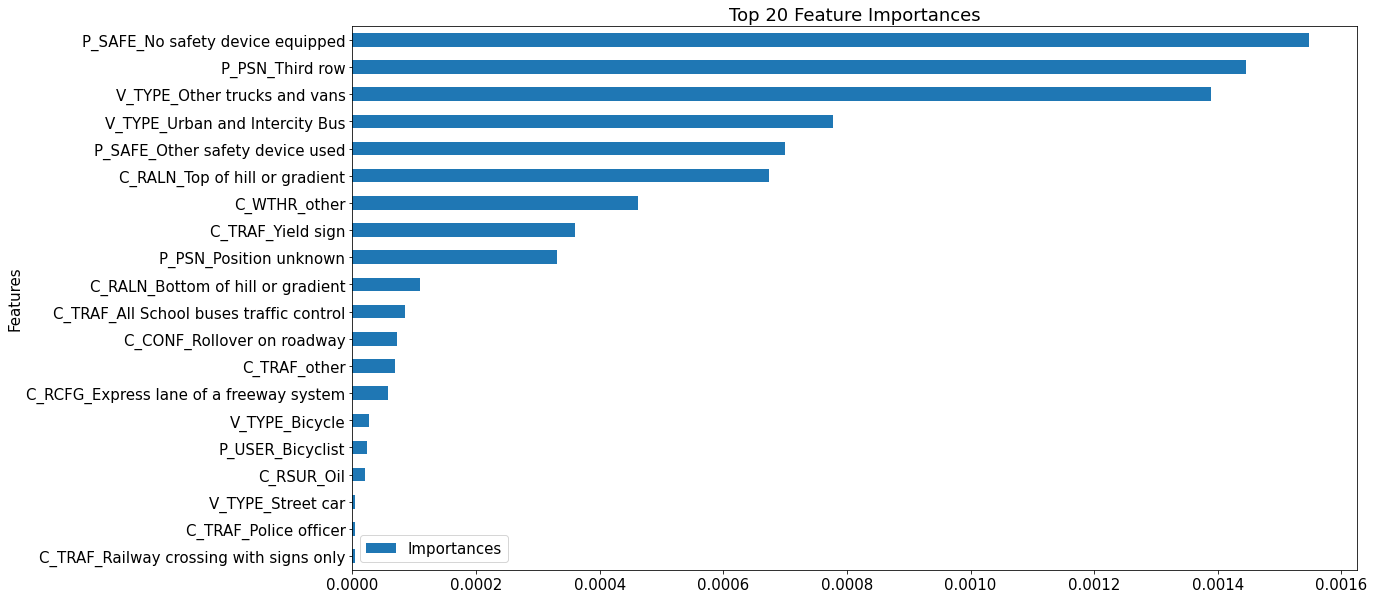

In [43]:
# Load trained model
rf_clf = joblib.load('../data/rf_clf.pkl')

# Compute feature importances
importances_df = pd.DataFrame({'Features': X_train_scaled.columns, 'Importances': rf_clf.feature_importances_})

# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.head(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances')

## B-3. XGBoost

In [ ]:
# Range of hyperparameters
params = {'subsample':[i/10 for i in range(5,9)],'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized search
xgb_model = xgb.XGBClassifier(n_estimators = 2000, random_state = 42,
                              scale_pos_weight = class_ratio, learning_rate = 0.1, 
                              min_child_weight = 5, max_depth = 9)
rsearch_xgb = RandomizedSearchCV(estimator = xgb_model, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                  random_state = 42, verbose = 1)  
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../data/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

# C. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## C-1. Under Sampling  combined with Random Forest Classifier
In undersampling, we reduce the majority class such that it matches the minority class

In [45]:
# Under sample the majority class
und = RandomUnderSampler(ratio = 'majority', random_state = 42)
X_train_scaled_und, y_train_und = und.fit_sample(X_train_scaled, y_train)

In [46]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (294, 78) (294,)


In [47]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [9015  147]
Undersampled training set class distribution: [147 147]


In [48]:
# Random Forest Classifier cross-validation on the undersampled dataset
rf_und = RandomForestClassifier(n_estimators = 1000,random_state = 42)
model.model_selection_cv(rf_und, X_train_scaled_und, y_train_und, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.792461 (0.052075)
AUROC: 0.867740
AUPRC: 0.894640
Predicted classes: [0 1]
Confusion matrix:
 [[126  21]
 [ 40 107]]
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       147
           1       0.84      0.73      0.78       147

    accuracy                           0.79       294
   macro avg       0.80      0.79      0.79       294
weighted avg       0.80      0.79      0.79       294

---------------------------------------------------------------------------


## C-2. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [49]:
# Over sample the minority class
sm = SMOTE(ratio = 'minority', random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_sample(X_train_scaled, y_train)

In [50]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (18030, 78) (18030,)


In [51]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [9015  147]
SMOTE resampled training set class distribution: [9015 9015]


In [52]:
# Random Forest cross-validation on the SMOTE dataset
rf_ovsm = RandomForestClassifier(random_state = 42)
model.model_selection_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.995286 (0.008738)
AUROC: 0.999686
AUPRC: 0.999715
Predicted classes: [0 1]
Confusion matrix:
 [[9009    6]
 [  79 8936]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       1.00      0.99      1.00      9015

    accuracy                           1.00     18030
   macro avg       1.00      1.00      1.00     18030
weighted avg       1.00      1.00      1.00     18030

---------------------------------------------------------------------------


## C-3. ROC and PR Curves on the Cross-Validation Training Set

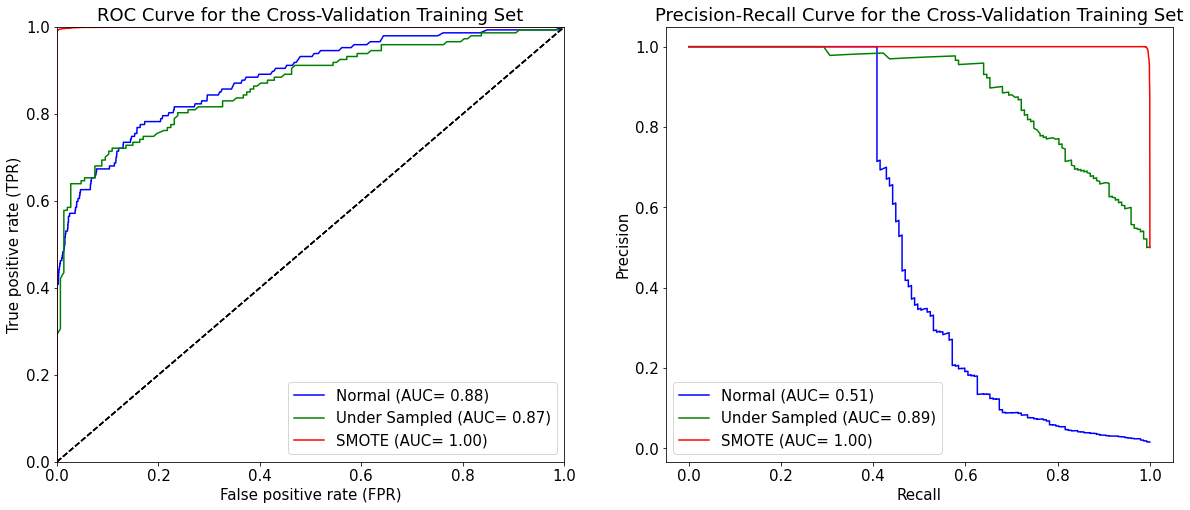

In [74]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.plot_roc_prc_cv(rf_clf, X_train_scaled, y_train,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Under Sampled distribution
model.plot_roc_prc_cv(rf_und, X_train_scaled_und, y_train_und,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# SMOTE distribution
model.plot_roc_prc_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# D. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## D-1. Normal Imbalanced Dataset

In [54]:
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.test_prediction(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.992143
AUROC: 0.898295
AUPRC: 0.589394
Predicted classes: [0 1]
Confusion matrix:
 [[2254    0]
 [  18   19]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2254
           1       1.00      0.51      0.68        37

    accuracy                           0.99      2291
   macro avg       1.00      0.76      0.84      2291
weighted avg       0.99      0.99      0.99      2291

---------------------------------------------------------------------------


## D-2. Undersampled Dataset

In [55]:
model.test_prediction(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.862942
AUROC: 0.892587
AUPRC: 0.494695
Predicted classes: [0 1]
Confusion matrix:
 [[1950  304]
 [  10   27]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      2254
           1       0.08      0.73      0.15        37

    accuracy                           0.86      2291
   macro avg       0.54      0.80      0.54      2291
weighted avg       0.98      0.86      0.91      2291

---------------------------------------------------------------------------


## D-3. SMOTE Dataset

In [56]:
model.test_prediction(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.992143
AUROC: 0.875267
AUPRC: 0.591628
Predicted classes: [0 1]
Confusion matrix:
 [[2254    0]
 [  18   19]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2254
           1       1.00      0.51      0.68        37

    accuracy                           0.99      2291
   macro avg       1.00      0.76      0.84      2291
weighted avg       0.99      0.99      0.99      2291

---------------------------------------------------------------------------


## D-4. ROC and PR Curves on the Test Set
The AUPRC of the normal imbalanced dataset is slightly higher than undersampling and SMOTE.

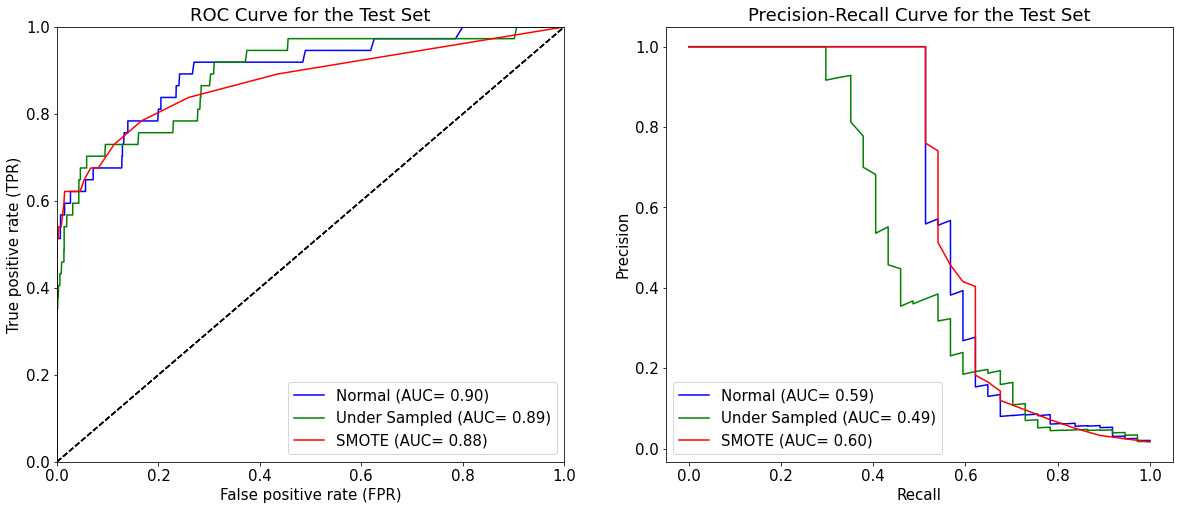

In [75]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.plot_roc_prc(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Under Sampled distribution
model.plot_roc_prc(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')

# SMOTE distribution
model.plot_roc_prc(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)')